In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_1 as fraunhofer
import apra_pop_models.props as props
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

In [9]:
model.npix/Nfpm / 0.025

9.765625

influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


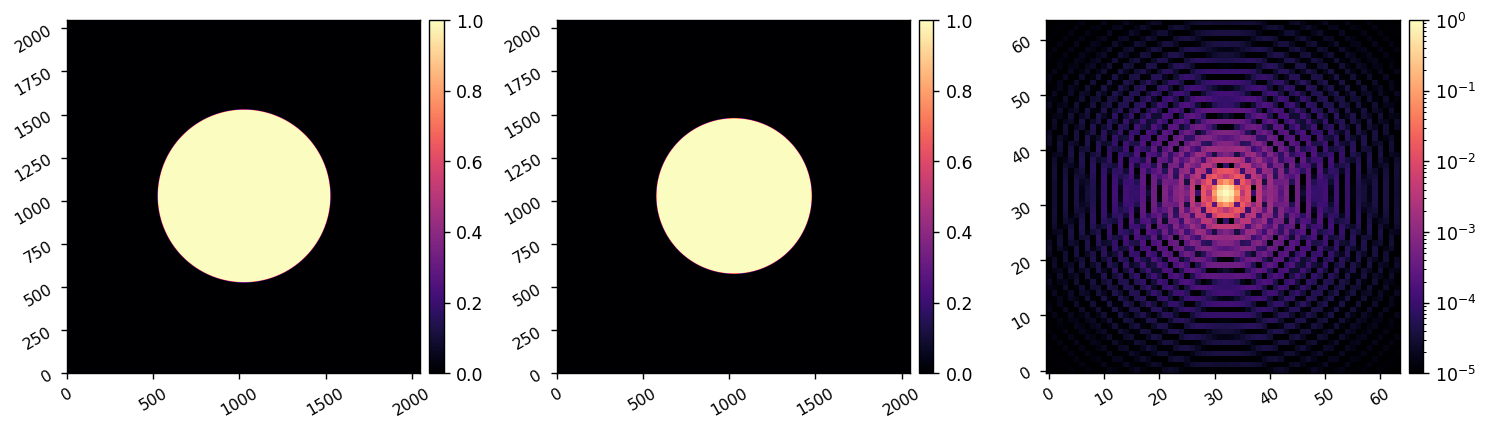

In [3]:
reload(fraunhofer)
model = fraunhofer.CORO()

N = 2048

fwf = poppy.FresnelWavefront(beam_radius=model.pupil_diam/2, wavelength=model.wavelength,
                                    npix=model.npix, oversample=N/model.npix)
# pupil_wf = xp.ones((model.N, model.N), dtype=complex)
pupil_wf = poppy.CircularAperture(radius=model.pupil_diam/2).get_transmission(fwf)
lyot_stop = poppy.CircularAperture(radius=0.9*model.pupil_diam/2).get_transmission(fwf)
ref_im = xp.abs(xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lyot_stop))) )**2

imshow3(pupil_wf, lyot_stop, ref_im/xp.max(ref_im), lognorm3=True, npix3=64, vmin3=1e-5)

In [38]:
np.savetxt('test-files/test_vortex_pupil.csv', pupil_wf, delimiter=',')

In [4]:
npix

NameError: name 'npix' is not defined

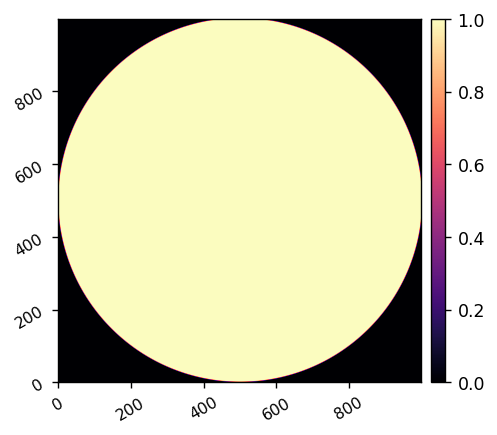

1000


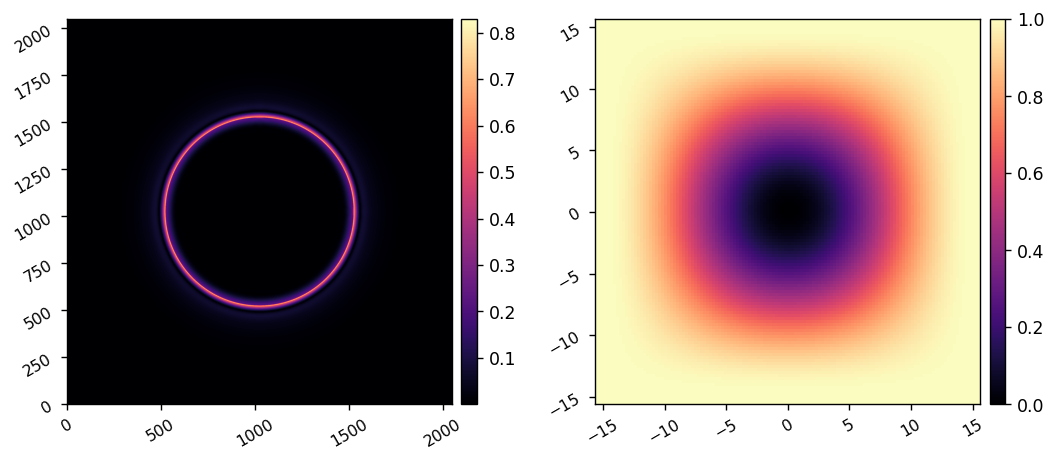

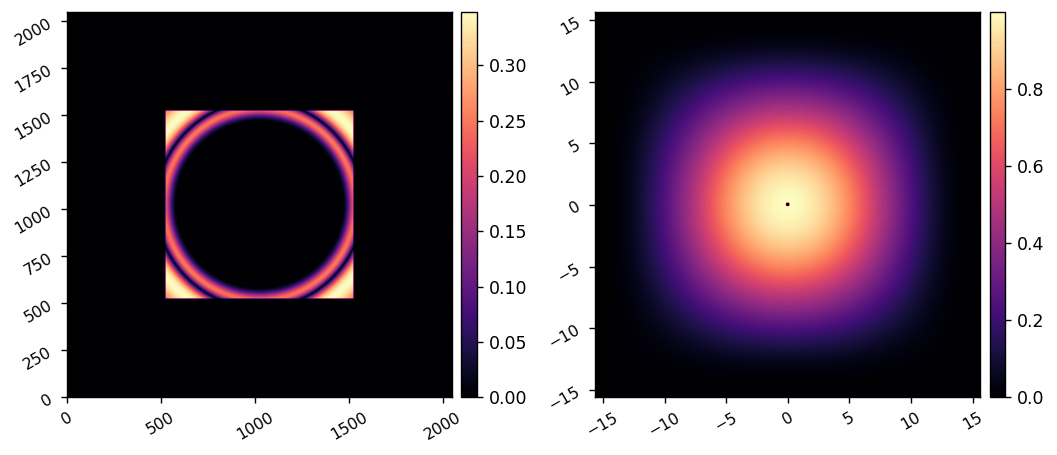

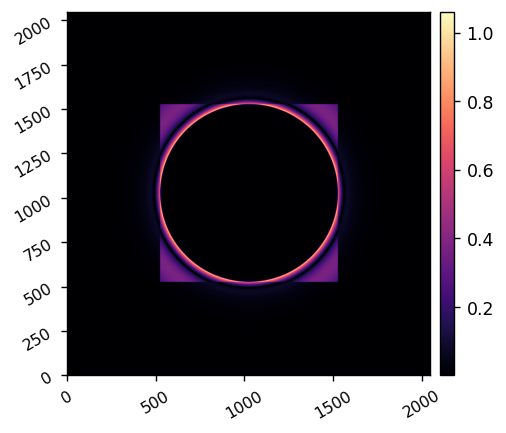

In [5]:
reload(props)
Nfpm = 4096
post_vortex_pupil = props.apply_vortex(utils.pad_or_crop(pupil_wf, model.npix), Nfpm, N, plot=True)

In [37]:
np.savetxt('test-files/test_vortex_output_real.csv', xp.real(post_vortex_pupil), delimiter=',')
np.savetxt('test-files/test_vortex_output_real.csv', xp.real(post_vortex_pupil), delimiter=',')

2.083149558193573e-09


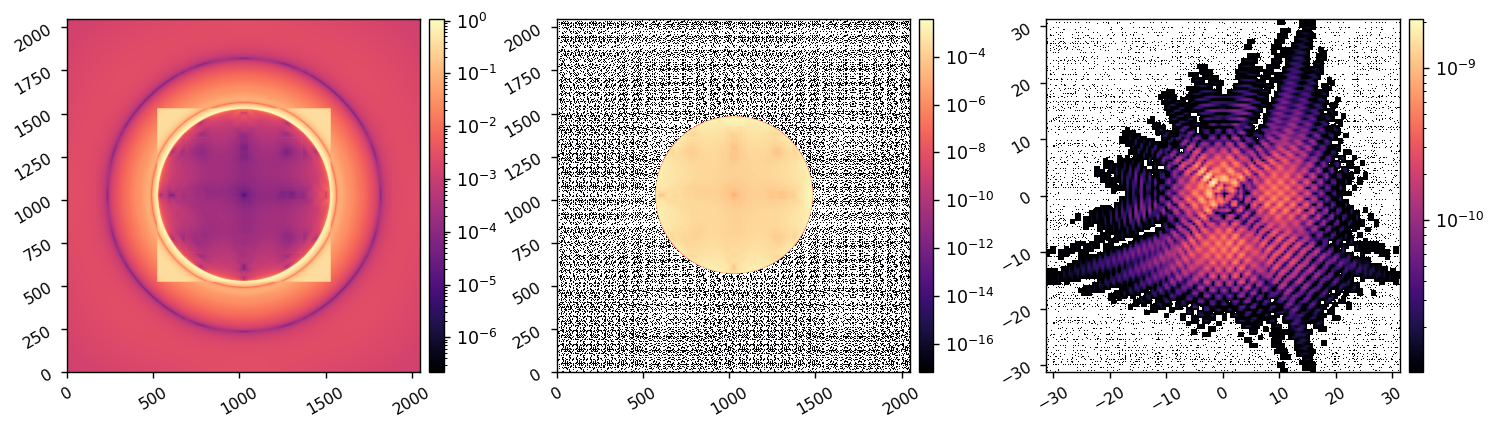

In [6]:
lyot_pupil = post_vortex_pupil * lyot_stop
vortex_im = xp.abs( xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lyot_pupil))) )**2 / ref_im.max()
print(xp.max(vortex_im))
imshow3(xp.abs(post_vortex_pupil), 
        xp.abs(lyot_pupil), 
        vortex_im * (vortex_im>1e-11), 
        npix3=128, lognorm=True, pxscl3=1/model.oversample)